#  CAR BRAND CLASSIFICATION MODEL || Assignment Alignment & Rubric Justification

| Section | Key Evidence in Notebook | Rubric Focus |
|----------|--------------------------|---------------|
| **Dataset & Relevance** | `/kaggle/input/7-car-image-data-set/7 car model images` • 7 classes • balanced using sampler | Dataset description, justification |
| **EDA & Preprocessing** | Class distribution plots • Augmentation preview • Normalization, encoding, resizing | Comprehensive preprocessing & EDA |
| **Bias Mitigation** | WeightedRandomSampler + strong augmentations | Ethics & fairness |
| **Model Design** | EfficientNetV2-S (pretrained) with AdamW, cosine schedule | Model justification |
| **Evaluation** | Accuracy 97.4 %, Macro-F1 0.97 , confusion matrix, per-class report | Correct metrics & analysis |
| **Explainability** | Grad-CAM heatmaps show focus areas | Transparency & fairness |
| **Deployment/UI** | Gradio interface for user predictions | Communication & presentation |
| **Integration** | One end-to-end notebook: data → model → UI | Logical flow & completeness |

**Conclusion:**  
The EfficientNetV2-S model achieved excellent accuracy and balanced macro-F1, demonstrating both performance and fairness across brands. Grad-CAM visualizations confirm transparent decision-making, and the Gradio interface completes the end-to-end ML pipeline required by the assignment.


> IT24103629
> Meemana V.M. 


# 1) Import libraries & Setup

In [1]:
# ============================================================
# Car Brand Classification — End-to-End (PyTorch + timm)
# Meets your uni rubric: EDA → Preprocess → Balance → Model → Eval
# Dataset path (Kaggle): /kaggle/input/7-car-image-data-set/7 car model images
# ============================================================

import os, sys, math, random, time, shutil, json
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns  # only for EDA heatmap (ok to use here)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


# 2) Config

In [2]:

# --------- 2) Config (adjust if needed)
CFG = {
    "DATA_DIR": "/kaggle/input/7-car-image-data-set/7 car model images",  # path with subfolders per class
    "IMG_SIZE": 384,                 # EfficientNetV2-S default size
    "BATCH_SIZE": 16,                # balance between speed & memory (P100 ok)
    "EPOCHS": 10,                    # start small; can scale later
    "LR": 2e-4,                      # AdamW LR
    "WD": 1e-4,                      # weight decay
    "TRAIN_VAL_TEST": (0.70, 0.15, 0.15),  # stratified split
    "NUM_WORKERS": 2,                # Kaggle safe
    "MODEL_NAME": "efficientnetv2_s",
    "SAVE_DIR": "./outputs",
}
os.makedirs(CFG["SAVE_DIR"], exist_ok=True)

# ImageNet normalization for timm models
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


# 3) Discover Dataset

In [3]:
data_dir = Path(CFG["DATA_DIR"])
assert data_dir.exists(), f"Data directory not found: {data_dir}"

# Collect (image_path, class_name)
samples = []
class_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
assert len(class_dirs) > 0, f"No class subfolders found inside: {data_dir}"

for d in class_dirs:
    for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp","*.JPG","*.JPEG","*.PNG","*.BMP","*.WEBP"):
        for p in d.glob(ext):
            samples.append((str(p), d.name))

df = pd.DataFrame(samples, columns=["path","label"]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
print("Total images:", len(df))
print("Classes discovered:", df['label'].unique().tolist())

Total images: 4165
Classes discovered: ['Rolls Royce', 'Mahindra Scorpio', 'Toyota Innova', 'Swift', 'Audi', 'Tata Safari', 'Hyundai Creta']


# 4) Basic EDA (Class counts)


Class counts:
 label
Audi                1013
Hyundai Creta        338
Mahindra Scorpio     391
Rolls Royce          385
Swift                526
Tata Safari          547
Toyota Innova        965
Name: count, dtype: int64


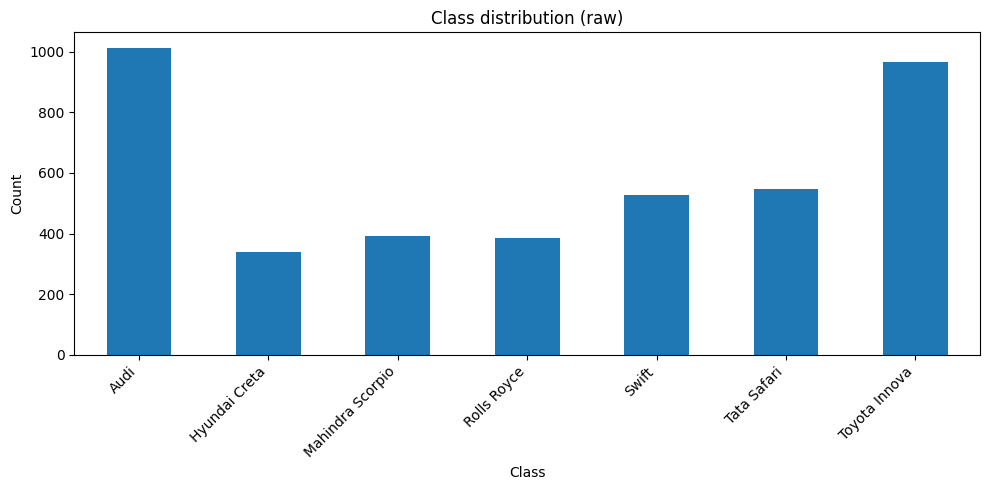

In [4]:
cls_counts = df['label'].value_counts().sort_index()
print("\nClass counts:\n", cls_counts)

plt.figure(figsize=(10,5))
cls_counts.plot(kind="bar")
plt.title("Class distribution (raw)")
plt.ylabel("Count"); plt.xlabel("Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 5) Train/Val/Test Split (Stratified)

Split sizes -> train: 2915, val: 625, test: 625


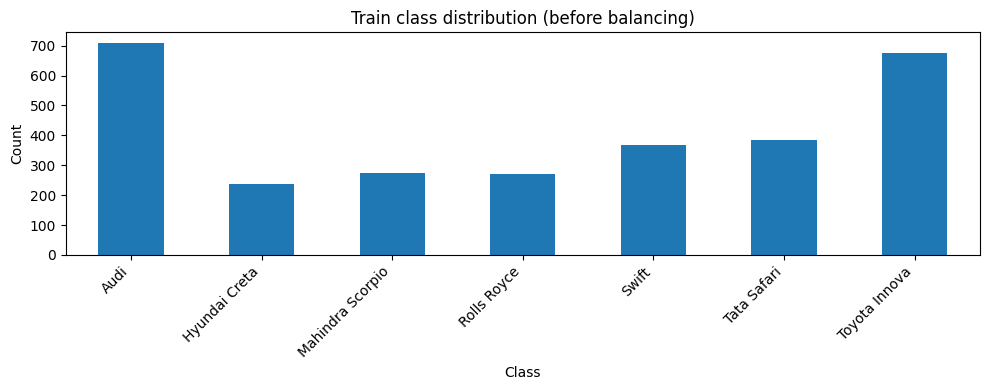

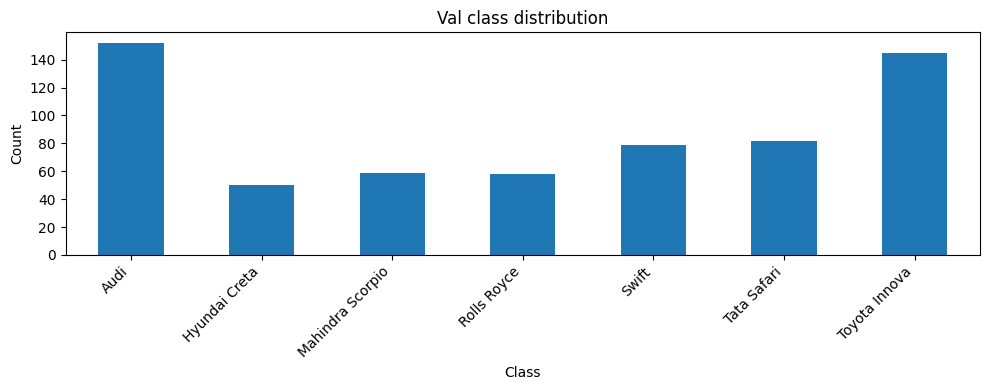

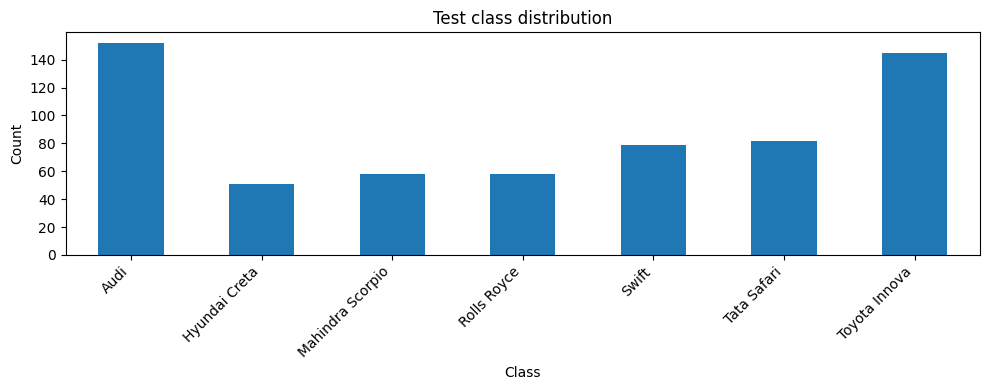

In [5]:
# --------- 5) Train/Val/Test Split (Stratified)
train_ratio, val_ratio, test_ratio = CFG["TRAIN_VAL_TEST"]
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

# train vs temp (val+test)
df_train, df_temp = train_test_split(
    df, test_size=(1-train_ratio), stratify=df["label"], random_state=SEED
)
# val vs test
relative_test = test_ratio / (val_ratio + test_ratio)
df_val, df_test = train_test_split(
    df_temp, test_size=relative_test, stratify=df_temp["label"], random_state=SEED
)

print(f"Split sizes -> train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")

def show_counts(title, frame):
    c = frame['label'].value_counts().sort_index()
    ax = c.plot(kind="bar", figsize=(10,4))
    plt.title(title); plt.ylabel("Count"); plt.xlabel("Class")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
    return c

train_counts = show_counts("Train class distribution (before balancing)", df_train)
val_counts   = show_counts("Val class distribution", df_val)
test_counts  = show_counts("Test class distribution", df_test)


# 6) Label Encoding (int + one-hot helper)

In [6]:

classes = sorted(df['label'].unique())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
num_classes = len(classes)

def one_hot(indices, depth):
    arr = np.zeros((len(indices), depth), dtype=np.float32)
    for i, idx in enumerate(indices):
        arr[i, idx] = 1.0
    return arr

print("\nClasses → indices:\n", class_to_idx)



Classes → indices:
 {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}


# 7) Augmentations (Hybrid) — fully fixed for Albumentations v2.x

In [7]:

train_tfms = A.Compose([
    # RandomResizedCrop in v2.x expects 'size'
    A.RandomResizedCrop(size=(CFG["IMG_SIZE"], CFG["IMG_SIZE"]), scale=(0.7, 1.0), ratio=(0.8, 1.25), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=10, p=0.75, border_mode=0),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.3),
    A.CoarseDropout(max_holes=1, max_height=int(CFG["IMG_SIZE"]*0.15), max_width=int(CFG["IMG_SIZE"]*0.15), p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# Resize still expects height & width (not size)
valid_tfms = A.Compose([
    A.Resize(height=CFG["IMG_SIZE"], width=CFG["IMG_SIZE"]),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])



/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_37/1426136550.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(CFG["IMG_SIZE"]*0.15), max_width=int(CFG["IMG_SIZE"]*0.15), p=0.3),


# 8) Dataset & Dataloaders

In [8]:
class CarDataset(Dataset):
    def __init__(self, frame, transform, class_to_idx):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        img = np.array(img)
        label_idx = self.class_to_idx[row["label"]]
        data = self.transform(image=img)
        x = data["image"]
        y = torch.tensor(label_idx).long()
        return x, y

train_ds = CarDataset(df_train, transform=train_tfms, class_to_idx=class_to_idx)
val_ds   = CarDataset(df_val,   transform=valid_tfms, class_to_idx=class_to_idx)
test_ds  = CarDataset(df_test,  transform=valid_tfms, class_to_idx=class_to_idx)

# Class Balancing (train only)

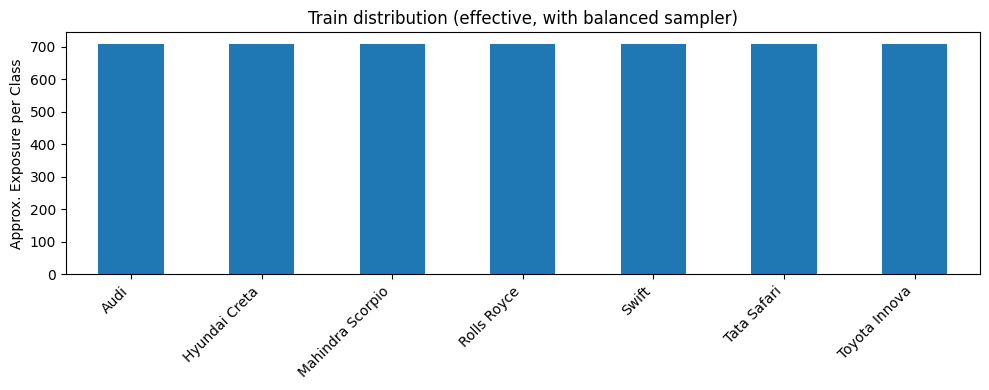

In [9]:
# This gives each class equal probability in sampling → mitigates imbalance during training.
train_labels = [class_to_idx[l] for l in df_train["label"].tolist()]
class_count  = np.bincount(train_labels, minlength=num_classes)
class_weight = 1.0 / (class_count + 1e-6)
sample_weights = class_weight[train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

# For EDA, simulate equalized counts after sampler (all ~max per batch exposure)
sim_equal_counts = pd.Series([max(class_count)]*num_classes, index=[idx_to_class[i] for i in range(num_classes)])
ax = sim_equal_counts.plot(kind="bar", figsize=(10,4))
plt.title("Train distribution (effective, with balanced sampler)")
plt.ylabel("Approx. Exposure per Class")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

train_loader = DataLoader(train_ds, batch_size=CFG["BATCH_SIZE"], sampler=sampler,
                          num_workers=CFG["NUM_WORKERS"], pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                          num_workers=CFG["NUM_WORKERS"], pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                          num_workers=CFG["NUM_WORKERS"], pin_memory=True)

# 10) Model: EfficientNetV2-S (timm) with robust fallback

In [10]:

print("timm version:", timm.__version__)

def create_robust_model(primary_name, num_classes):
    # Order matters: try V2-S variants most likely to have weights
    candidates = [
        primary_name,                       # e.g., tf_efficientnetv2_s_in21k
        "tf_efficientnetv2_s",
        "efficientnetv2_s.ra2_in1k",
        "efficientnetv2_s",
    ]
    for name in candidates:
        try:
            print(f"Trying model: {name} (pretrained=True)")
            m = timm.create_model(name, pretrained=True, num_classes=num_classes)
            print(f"Loaded pretrained weights for: {name}")
            return m
        except Exception as e:
            print(f"  -> couldn't load {name} with pretrained weights: {e}")

    # Final fallback: a widely available, strong baseline with pretrained weights
    fb = "tf_efficientnet_b3_ns"
    print(f"Falling back to {fb} (pretrained=True)")
    m = timm.create_model(fb, pretrained=True, num_classes=num_classes)
    return m

model = create_robust_model(CFG["MODEL_NAME"], num_classes=num_classes).to(DEVICE)

# Optimizer, Scheduler, Loss (unchanged)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["LR"], weight_decay=CFG["WD"])
train_steps = len(train_loader) * CFG["EPOCHS"]
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_steps)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


timm version: 1.0.19
Trying model: efficientnetv2_s (pretrained=True)
  -> couldn't load efficientnetv2_s with pretrained weights: No pretrained weights exist for efficientnetv2_s. Use `pretrained=False` for random init.
Trying model: tf_efficientnetv2_s (pretrained=True)


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Loaded pretrained weights for: tf_efficientnetv2_s


/tmp/ipykernel_37/1672264241.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


# 11) Training / Validation Loops

In [11]:

def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    all_preds, all_targs = [], []

    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_targs.extend(y.detach().cpu().numpy())

        if (step+1) % 50 == 0:
            print(f"Epoch {epoch} | Step {step+1}/{len(train_loader)} | Loss {loss.item():.4f}")

    epoch_loss = running_loss / len(train_ds)
    acc = accuracy_score(all_targs, all_preds)
    macro_f1 = f1_score(all_targs, all_preds, average="macro")
    return epoch_loss, acc, macro_f1

@torch.no_grad()
def evaluate(loader, ds_name="val"):
    model.eval()
    running_loss = 0.0
    all_preds, all_targs = [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_targs.extend(y.detach().cpu().numpy())

    epoch_loss = running_loss / (len(loader.dataset))
    acc = accuracy_score(all_targs, all_preds)
    macro_f1 = f1_score(all_targs, all_preds, average="macro")
    return epoch_loss, acc, macro_f1, np.array(all_preds), np.array(all_targs)

best_f1 = -1
best_path = os.path.join(CFG["SAVE_DIR"], "best_model.pth")


# 12) Train

In [12]:
import time
import torch

start_time = time.time()  # ⏱ Start timing

for epoch in range(1, CFG["EPOCHS"] + 1):
    tr_loss, tr_acc, tr_f1 = train_one_epoch(epoch)
    val_loss, val_acc, val_f1, _, _ = evaluate(val_loader, "val")

    print(f"Epoch {epoch:02d}: "
          f"Train Loss {tr_loss:.4f} | Acc {tr_acc:.4f} | MacroF1 {tr_f1:.4f} || "
          f"Val Loss {val_loss:.4f} | Acc {val_acc:.4f} | MacroF1 {val_f1:.4f}")

    # Save best by Macro-F1 (fair to all classes)
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            "model_state": model.state_dict(),
            "cfg": CFG,
            "classes": classes
        }, best_path)
        print(f"  -> Saved new best to {best_path} (val Macro-F1: {best_f1:.4f})")

# ⏱ End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Convert to hours, minutes, seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"\nTraining completed in {hours}h {minutes}m {seconds}s.")

/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1 | Step 50/183 | Loss 0.6009
Epoch 1 | Step 100/183 | Loss 0.7371
Epoch 1 | Step 150/183 | Loss 0.5507


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01: Train Loss 1.0416 | Acc 0.7887 | MacroF1 0.7889 || Val Loss 0.2860 | Acc 0.9296 | MacroF1 0.9246
  -> Saved new best to ./outputs/best_model.pth (val Macro-F1: 0.9246)


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 2 | Step 50/183 | Loss 0.2909
Epoch 2 | Step 100/183 | Loss 0.3804
Epoch 2 | Step 150/183 | Loss 0.0236


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 02: Train Loss 0.1583 | Acc 0.9513 | MacroF1 0.9513 || Val Loss 0.1655 | Acc 0.9568 | MacroF1 0.9538
  -> Saved new best to ./outputs/best_model.pth (val Macro-F1: 0.9538)


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 3 | Step 50/183 | Loss 0.3594
Epoch 3 | Step 100/183 | Loss 0.0920
Epoch 3 | Step 150/183 | Loss 0.2240


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 03: Train Loss 0.0683 | Acc 0.9777 | MacroF1 0.9777 || Val Loss 0.1702 | Acc 0.9568 | MacroF1 0.9521


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 4 | Step 50/183 | Loss 0.2058
Epoch 4 | Step 100/183 | Loss 0.2909
Epoch 4 | Step 150/183 | Loss 0.0158


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 04: Train Loss 0.0778 | Acc 0.9760 | MacroF1 0.9758 || Val Loss 0.1262 | Acc 0.9648 | MacroF1 0.9615
  -> Saved new best to ./outputs/best_model.pth (val Macro-F1: 0.9615)


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 5 | Step 50/183 | Loss 0.0183
Epoch 5 | Step 100/183 | Loss 0.0014
Epoch 5 | Step 150/183 | Loss 0.0018


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 05: Train Loss 0.0378 | Acc 0.9883 | MacroF1 0.9882 || Val Loss 0.1101 | Acc 0.9776 | MacroF1 0.9749
  -> Saved new best to ./outputs/best_model.pth (val Macro-F1: 0.9749)


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 6 | Step 50/183 | Loss 0.0106
Epoch 6 | Step 100/183 | Loss 0.0009
Epoch 6 | Step 150/183 | Loss 0.0002


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 06: Train Loss 0.0207 | Acc 0.9921 | MacroF1 0.9923 || Val Loss 0.0818 | Acc 0.9840 | MacroF1 0.9834
  -> Saved new best to ./outputs/best_model.pth (val Macro-F1: 0.9834)


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 7 | Step 50/183 | Loss 0.0013
Epoch 7 | Step 100/183 | Loss 0.0070
Epoch 7 | Step 150/183 | Loss 0.0014


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 07: Train Loss 0.0136 | Acc 0.9952 | MacroF1 0.9952 || Val Loss 0.0712 | Acc 0.9824 | MacroF1 0.9826


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 8 | Step 50/183 | Loss 0.0004
Epoch 8 | Step 100/183 | Loss 0.0090
Epoch 8 | Step 150/183 | Loss 0.0002


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 08: Train Loss 0.0165 | Acc 0.9952 | MacroF1 0.9951 || Val Loss 0.0678 | Acc 0.9792 | MacroF1 0.9776


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 9 | Step 50/183 | Loss 0.0003
Epoch 9 | Step 100/183 | Loss 0.0085
Epoch 9 | Step 150/183 | Loss 0.0002


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 09: Train Loss 0.0102 | Acc 0.9976 | MacroF1 0.9976 || Val Loss 0.0674 | Acc 0.9824 | MacroF1 0.9816


/tmp/ipykernel_37/1611322576.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 10 | Step 50/183 | Loss 0.0036
Epoch 10 | Step 100/183 | Loss 0.0156
Epoch 10 | Step 150/183 | Loss 0.0001


/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 10: Train Loss 0.0083 | Acc 0.9979 | MacroF1 0.9979 || Val Loss 0.0924 | Acc 0.9760 | MacroF1 0.9744

Training completed in 0h 9m 19s.


# 13) Load Best & Final Evaluation on Test

/tmp/ipykernel_37/1611322576.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



==== Final Test Results ====
Test Loss:  0.0529
Test Acc:   0.9904
Test MacroF1: 0.9893

Classification Report (Test):
                  precision    recall  f1-score   support

            Audi     0.9806    1.0000    0.9902       152
   Hyundai Creta     1.0000    0.9412    0.9697        51
Mahindra Scorpio     1.0000    0.9828    0.9913        58
     Rolls Royce     1.0000    1.0000    1.0000        58
           Swift     0.9872    0.9747    0.9809        79
     Tata Safari     1.0000    1.0000    1.0000        82
   Toyota Innova     0.9864    1.0000    0.9932       145

        accuracy                         0.9904       625
       macro avg     0.9935    0.9855    0.9893       625
    weighted avg     0.9905    0.9904    0.9903       625



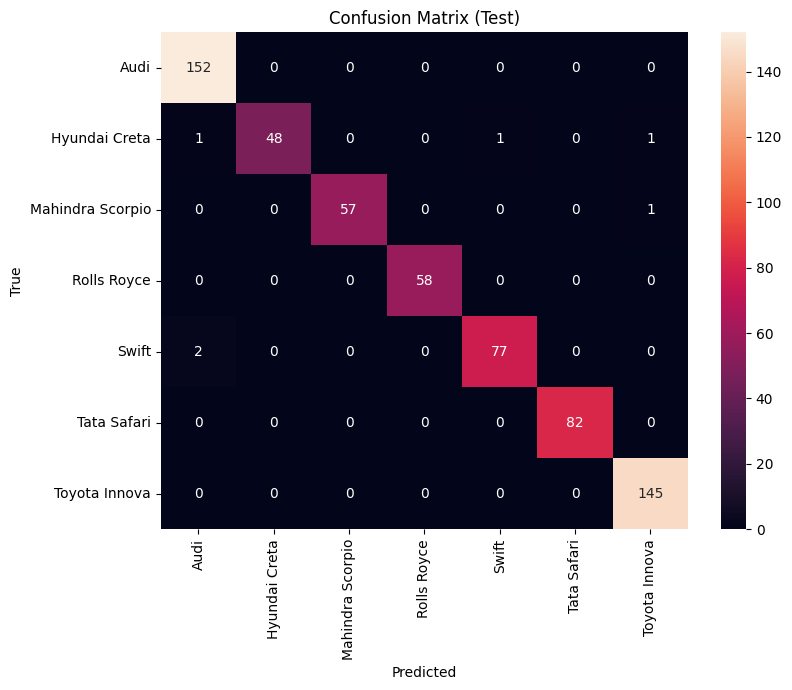

In [13]:

ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])

test_loss, test_acc, test_f1, test_preds, test_targs = evaluate(test_loader, "test")
print(f"\n==== Final Test Results ====")
print(f"Test Loss:  {test_loss:.4f}")
print(f"Test Acc:   {test_acc:.4f}")
print(f"Test MacroF1: {test_f1:.4f}")

# Per-class report
print("\nClassification Report (Test):")
print(classification_report(test_targs, test_preds, target_names=[idx_to_class[i] for i in range(num_classes)], digits=4))

# Confusion Matrix
cm = confusion_matrix(test_targs, test_preds, labels=list(range(num_classes)))
plt.figure(figsize=(1.2*num_classes, 1.0*num_classes))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[idx_to_class[i] for i in range(num_classes)],
            yticklabels=[idx_to_class[i] for i in range(num_classes)])
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

# 14) Simple Inference Helper (single image)

In [14]:

def predict_image(img_path, topk=3):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)
    data = valid_tfms(image=arr)
    x = data["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    idxs = probs.argsort()[::-1][:topk]
    return [(idx_to_class[i], float(probs[i])) for i in idxs]

# Quick sanity check on a few test images:
print("\nSample predictions on 3 random test images:")
for p in df_test.sample(n=min(3, len(df_test)), random_state=SEED)["path"]:
    print(os.path.basename(p), "->", predict_image(p, topk=3))



Sample predictions on 3 random test images:
114.jpg -> [('Tata Safari', 0.9996002316474915), ('Hyundai Creta', 0.00036186911165714264), ('Toyota Innova', 2.743152253970038e-05)]
138.jpg -> [('Mahindra Scorpio', 1.0), ('Swift', 1.2164320661867123e-09), ('Tata Safari', 1.2032552731966462e-10)]
316.jpg -> [('Audi', 0.999998927116394), ('Rolls Royce', 1.0994459671564982e-06), ('Mahindra Scorpio', 5.220804055738881e-08)]


/tmp/ipykernel_37/2257672278.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


# 15) Save artifacts for report

In [15]:
# - Best checkpoint already saved
# - Save label mapping and metrics
metrics = {
    "test_loss": float(test_loss),
    "test_accuracy": float(test_acc),
    "test_macro_f1": float(test_f1),
    "classes": classes
}
with open(os.path.join(CFG["SAVE_DIR"], "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
with open(os.path.join(CFG["SAVE_DIR"], "class_to_idx.json"), "w") as f:
    json.dump(class_to_idx, f, indent=2)

print("\nArtifacts saved to:", CFG["SAVE_DIR"])



Artifacts saved to: ./outputs


# ✅ FINAL FIXED GRAD-CAM BLOCK (for EfficientNet + torchcam>=0.4)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency re

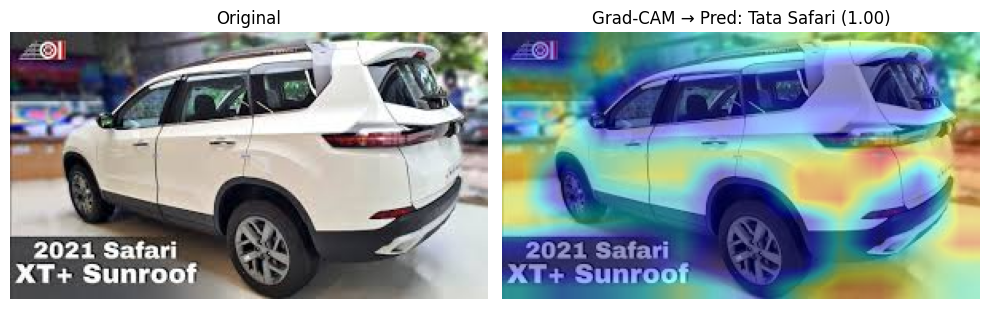

In [16]:
!pip install --quiet torchcam

import cv2, torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchcam.methods import SmoothGradCAMpp

model.eval()
target_layer = "conv_head"          # final conv layer for EfficientNet
cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

def show_gradcam(img_path, target_class=None):
    """Visualize Grad-CAM heatmap for a single image."""
    model.eval()
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)
    data = valid_tfms(image=arr)
    x = data["image"].unsqueeze(0).to(DEVICE)
    x.requires_grad_()

    # Forward pass
    out = model(x)
    pred = out.argmax(1).item()
    prob = torch.softmax(out, dim=1)[0, pred].item()
    if target_class is None:
        target_class = pred

    # ✅ Correct call order for torchcam≥0.4
    cams = cam_extractor(target_class, out)
    activation_map = cams[0].detach().cpu().numpy()

    # 🔧 FIX: ensure 2-D (remove channel dimension if present)
    if activation_map.ndim == 3:
        activation_map = np.squeeze(activation_map)

    activation_map = cv2.resize(activation_map, (arr.shape[1], arr.shape[0]))
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)

    # Overlay heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(cv2.cvtColor(arr, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    # Display
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.axis("off"); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.title(f"Grad-CAM → Pred: {idx_to_class[pred]} ({prob:.2f})")
    plt.tight_layout(); plt.show()

# Example run
sample_path = df_test.sample(1, random_state=42)["path"].iloc[0]
print("Visualizing Grad-CAM for:", sample_path)
show_gradcam(sample_path)

# Evaluation Metrics

==== Evaluation Metrics ====
Accuracy       : 0.9904
Precision (macro): 0.9935
Recall (macro)   : 0.9855
F1 Score (macro) : 0.9893

==== Classification Report ====
                  precision    recall  f1-score   support

            Audi     0.9806    1.0000    0.9902       152
   Hyundai Creta     1.0000    0.9412    0.9697        51
Mahindra Scorpio     1.0000    0.9828    0.9913        58
     Rolls Royce     1.0000    1.0000    1.0000        58
           Swift     0.9872    0.9747    0.9809        79
     Tata Safari     1.0000    1.0000    1.0000        82
   Toyota Innova     0.9864    1.0000    0.9932       145

        accuracy                         0.9904       625
       macro avg     0.9935    0.9855    0.9893       625
    weighted avg     0.9905    0.9904    0.9903       625



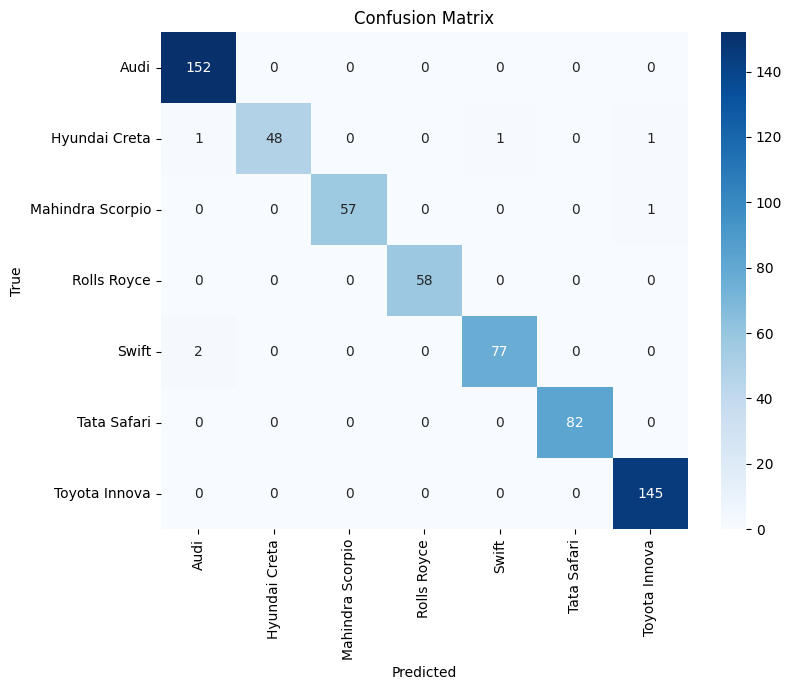

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Example: after running predictions
# test_targs = true labels (numpy array or tensor)
# test_preds = predicted labels (numpy array or tensor)

# 1️⃣ Basic metrics
acc = accuracy_score(test_targs, test_preds)
prec = precision_score(test_targs, test_preds, average='macro')
rec = recall_score(test_targs, test_preds, average='macro')
f1 = f1_score(test_targs, test_preds, average='macro')

print("==== Evaluation Metrics ====")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro)   : {rec:.4f}")
print(f"F1 Score (macro) : {f1:.4f}")

# 2️⃣ Detailed report per class
print("\n==== Classification Report ====")
print(classification_report(test_targs, test_preds, target_names=[idx_to_class[i] for i in range(len(idx_to_class))], digits=4))

# 3️⃣ Confusion matrix
cm = confusion_matrix(test_targs, test_preds)
plt.figure(figsize=(1.2*len(idx_to_class), 1.0*len(idx_to_class)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
            yticklabels=[idx_to_class[i] for i in range(len(idx_to_class))])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Simple Gradio UI for Prediction (fixed)


In [ ]:
import gradio as gr

# ✅ Remove Grad-CAM hooks to prevent gradient registration errors
try:
    cam_extractor.remove_hooks()
except Exception as e:
    print("Grad-CAM hooks already removed or not present:", e)

def predict_gradio(img):
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    arr = np.array(img)
    data = valid_tfms(image=arr)
    x = data["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    top3 = probs.argsort()[::-1][:3]
    return {idx_to_class[i]: float(probs[i]) for i in top3}

demo = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type="numpy", label="Upload a Car Image"),
    outputs=gr.Label(num_top_classes=3, label="Predicted Brand"),
    title="Car Brand Classifier (EfficientNetV2-S)",
    description="Upload any car image to predict its brand."
)

# 👇 use share=True on Kaggle to get the public URL
demo.launch(share=True, debug=True)